# Домашняя работа, Игнатьев Д. Д.

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics.pairwise import cosine_distances, cosine_similarity

from IPython.display import Image
from IPython.core.display import HTML 

## TF-IDF

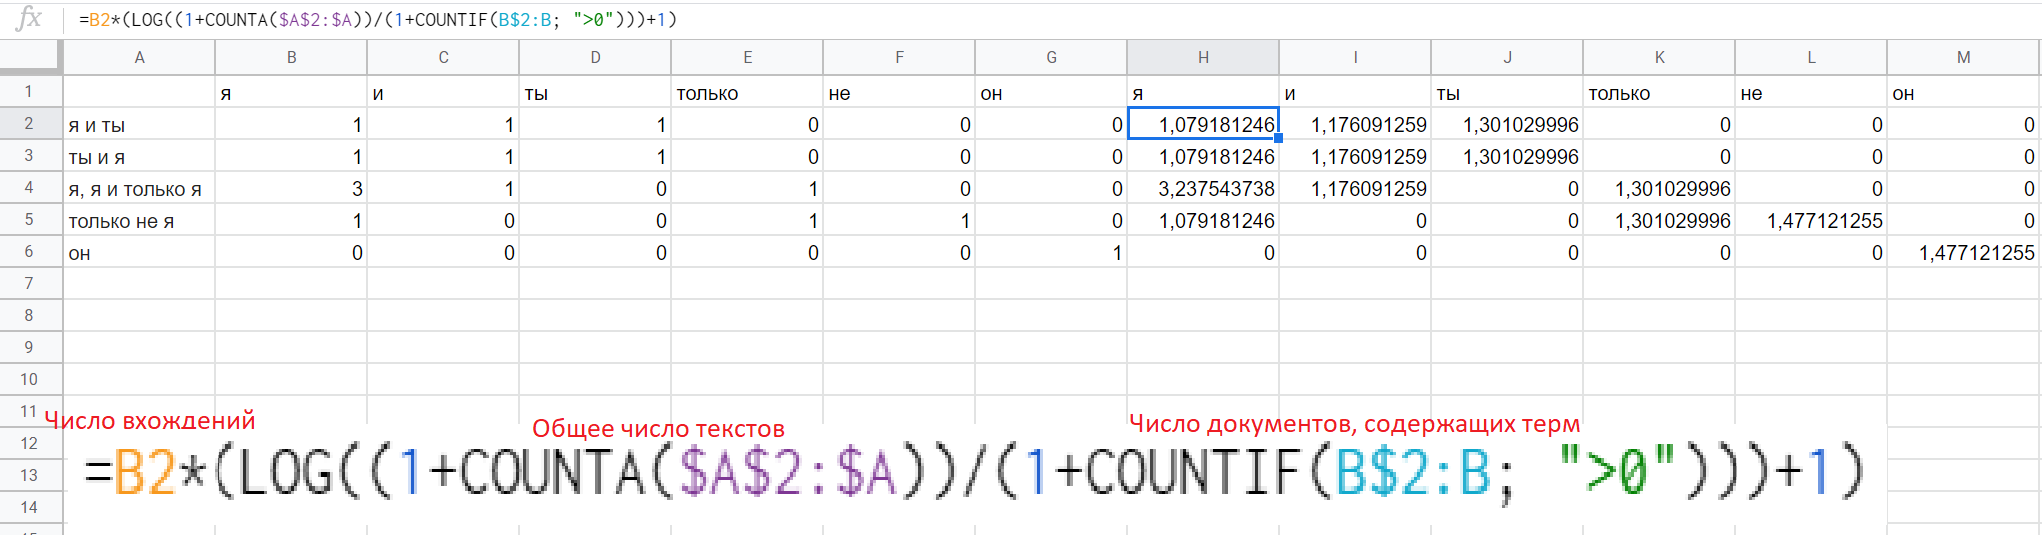

In [6]:
Image(data="tfIdf.png",
     width=1000, height=500)

## Близости текстов

In [55]:
data = pd.read_csv('labeled.csv')

In [56]:
data.head()

,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0
2,Собаке - собачья смерть\n,1.0
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0


In [15]:
vectorizer = TfidfVectorizer(min_df=6, max_df=0.5, max_features=1500)
X = vectorizer.fit_transform(data.comment)

### Комментарий: в двух постах нет совпадающих слов, поэтому косинусная близость в любом случае будет нулевой

In [18]:
print(data["comment"][2])
print(data["comment"][12665])

Собаке - собачья смерть

ну, как же: от Владивостока до ЮЖХ 1700 км по автодорогам, а между ними Татарский пролив)



In [39]:
cosine_similarity(X[2], X[12665])

array([[0.]])

### Близкие тексты

In [40]:
dist = cosine_distances(X[42], X)
dist.argsort()[0,:4]

array([  42, 1983, 2168, 2044], dtype=int64)

In [53]:
for index in [1983, 2168, 2044]:
    print(f"Косинусная близость: {1-dist[:,index]}")
    text = data.loc[[index], "comment"]
    print(f"Текст: {text}")
    print("\n")

Косинусная близость: [0.54327201]
Текст: 1983    регулярно игнорировались После чего орда прихо...
Name: comment, dtype: object


Косинусная близость: [0.49476779]
Текст: 2168    что генетически русские ебать даун\n
Name: comment, dtype: object


Косинусная близость: [0.48523005]
Текст: 2044    РРЯЯЯЯ, КУБАНОИДЫ НЕ РУССКИЕ, НАХУЙ ВЫ НУЖНЫ К...
Name: comment, dtype: object




## Классификация

In [64]:
with open(file="../2ch_corpus.txt", mode="r", encoding="UTF-8") as dvach:
    texts = dvach.read().split("\n")
    ye_olde_texts = pd.DataFrame(data=texts, columns=["text"])

In [65]:
ye_olde_texts.head(5)

,text
0,Анимублядский WebM-треддля приличных анимубля...
1,"Посоны, поделитесь ссылкой на ютуб-версию..."
2,"Побольше тебе стандопавера, бро."
3,Перекатился. Благословил.
4,У меня нофап- мне туда даже заходить нельзя


### Мерджим таблицы

In [71]:
print(data["comment"].shape)
print(ye_olde_texts["text"].shape)

(14412,)
(85904,)


In [94]:
merged = pd.concat([data["comment"], ye_olde_texts["text"]], axis=0)

In [98]:
merged.shape

(100316,)

### Обучение векторайзеров

In [66]:
from nltk.tokenize import RegexpTokenizer

In [67]:
tokenizer = RegexpTokenizer(r"\w+")

In [76]:
C_vectorizer = CountVectorizer(min_df=6, max_df=0.5, lowercase=True, tokenizer=tokenizer.tokenize, max_features=3000, ngram_range=(1,2))
T_vectorizer = TfidfVectorizer(min_df=6, max_df=0.5, lowercase=True, tokenizer=tokenizer.tokenize, max_features=3000, ngram_range=(1,2))

In [77]:
counts = C_vectorizer.fit_transform(merged)
tfs = T_vectorizer.fit_transform(merged)

In [106]:
X_C = counts[:14412,:]
X_predict_C = counts[14412:,:]
X_T = tfs[:14412,:]
X_predict_T = tfs[14412:,:]

In [109]:
y = data.toxic

### Деление на трейн-тест

Для того, чтобы понять качество обученной модели нам нужно разделить данные на обучающую и тестовую выборку.

In [110]:
X_C_train, X_C_test, y_C_train, y_C_test = train_test_split(X_C, y, test_size=0.1, shuffle=True)
X_T_train, X_T_test, y_T_train, y_T_test = train_test_split(X_T, y, test_size=0.1, shuffle=True)

In [125]:
clf_log = LogisticRegression(C=1, n_jobs=3)
clf_NB = MultinomialNB(alpha=1., fit_prior=False)

### ОБучение

In [126]:
clf_log.fit(X_C_train, y_C_train)
predict_log = clf_log.predict(X_C_test)
print(classification_report(y_C_test, predict_log))

              precision    recall  f1-score   support

         0.0       0.83      0.89      0.86       937
         1.0       0.76      0.66      0.71       505

    accuracy                           0.81      1442
   macro avg       0.80      0.77      0.78      1442
weighted avg       0.81      0.81      0.81      1442



In [127]:
clf_NB.fit(X_T_train, y_T_train)
predict_NB = clf_NB.predict(X_T_test)
print(classification_report(y_T_test, predict_NB))

              precision    recall  f1-score   support

         0.0       0.85      0.88      0.87       949
         1.0       0.75      0.71      0.73       493

    accuracy                           0.82      1442
   macro avg       0.80      0.79      0.80      1442
weighted avg       0.82      0.82      0.82      1442



In [129]:
toxic_log = clf_log.predict_proba(X_predict_C)
toxic_NB = clf_NB.predict_proba(X_predict_T)

### Результаты

In [132]:
ye_olde_texts["toxic_log"] = [n[1] for n in toxic_log]
ye_olde_texts["toxic_NB"] = [n[1] for n in toxic_NB]

In [135]:
ye_olde_texts.sort_values("toxic_NB", ascending=False).head(10)

,text,toxic_log,toxic_NB
51892,"Че ебать, еблет закрой. Есть блять тебе по еб...",1.000000,0.999269
78161,Ебаный школьник как ты заебал блядь рот твой ...,0.999990,0.999228
30710,Я ЕБАЛ ТЕБЯ В РОТ ЙОХАН И МАТЬ ТВОЮ ШЛЮХУ СП...,0.999950,0.998991
51907,Обосрался? Ахуеть ты блять чмошник. Вы тольк...,1.000000,0.998647
33918,"Сказочный долбоёб просто. Нахуй ты убежал, де...",1.000000,0.998646
71359,"Иди нахуй, всем похуй на твой тред и говно бр...",0.999882,0.998507
41658,Маня Быдло За щёку Бугурт Бомбануло Пригорел ...,1.000000,0.998443
28369,Что ты здесь извиваешься петух? За шлюху свою...,0.999989,0.998099
83364,Я ебал твою мамашу Сходи нюхни трусы своего п...,0.999974,0.998025
59820,Ты дебил тупой блять читай пуе хуесосина преж...,1.000000,0.997979


In [139]:
ye_olde_texts.sort_values("toxic_log", ascending=False).head(10)

,text,toxic_log,toxic_NB
65189,"Бомжиха Света Было это, когда я учился в шест...",1.0,0.946105
75128,"ИЩЕМ ШКУР, КОТОРЫЕ СНИМАЛИСЬ В ПОРНО ИЛИ РАБ...",1.0,0.891571
67154,"Сап, двощ! Пишу тебе с большой просьбой к адм...",1.0,0.906598
51892,"Че ебать, еблет закрой. Есть блять тебе по еб...",1.0,0.999269
67089,ХВАТИТ УЖЕ ДУМАТЬ ОБ ЭТОМ. ТЫ ПРОСТО ИСПОЛЬЗУ...,1.0,0.981874
64360,"Когда я вижу такие треды, я не чувствую нен...",1.0,0.984079
37188,"""Понимание"" — оно в процессе отношений и даже...",1.0,0.980289
67551,>Наверняка тебе не раз приходила в голову так...,1.0,0.978702
65197,История про цирк Мы с корешем срали под дверь...,1.0,0.966062
37240,Вот так вот почитаешь пасты про всех этих пёз...,1.0,0.975902


#### Совпадает текст 51892. В большинстве текстов присутствует обсценная лексика, что служит для алгоритма показателем токсичности. Прогнозы классификаторов для "топовых" текстов почти не расходятся, оба предсказывают высокую вероятность.

In [140]:
import eli5

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [141]:
eli5.show_weights(clf_log, top=20, feature_names=T_vectorizer.get_feature_names())

Weight?,Feature
+3.605,хохлов
+3.478,хохлы
+2.839,дебил
+2.797,тупые
+2.493,сука
+2.455,хуйню
+2.426,русских
+2.409,моча
+2.327,бабы
+2.316,блять
